In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from liquidity.util.utils import compute_returns
from liquidity.util.fitting_util import get_agg_features

from hurst_exponent.acf import nonlinear_acf
from hurst_exponent.util.utils import interpret_hurst
from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst

from powerlaw_function.powerlaw_function import Fit

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Number of lags for the ACF
ACF_RANGE = 1001

# Window/bin size for imbalances
T = 100

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Order flow

### 1.1. Return magnitudes

In [5]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns_magnitudes = {
  'TSLA': abs(tsla_returns),
  'MSFT': abs(msft_returns),
  'AMZN': abs(amzn_returns),
  'NFLX': abs(nflx_returns),
  'EBAY': abs(ebay_returns),
  'APPL': abs(appl_returns)
}

###  1.2. Signs

In [6]:
# Signed orderflow
signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['trade_sign']
}

### 1.3. Signed Volume

In [7]:
# Signed Volume
signed_volume = {
  'TSLA': tsla_raw_df['norm_trade_volume'] * tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['norm_trade_volume'] * msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['norm_trade_volume'] * amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['norm_trade_volume'] * nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['norm_trade_volume'] * ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['norm_trade_volume'] * appl_raw_df['trade_sign']
}

### 1.3. Signed Ordeflow Imbalance

In [8]:
# Aggregate orderflow
tsla_imbalance = get_agg_features(tsla_raw_df, [T])
msft_imbalance = get_agg_features(tsla_raw_df, [T])
amzn_imbalance= get_agg_features(tsla_raw_df, [T])
nflx_imbalance = get_agg_features(tsla_raw_df, [T])
ebay_imbalance = get_agg_features(tsla_raw_df, [T])
appl_imbalance = get_agg_features(tsla_raw_df, [T])

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_imbalance['sign_imbalance'],
  'MSFT': msft_imbalance['sign_imbalance'],
  'AMZN': amzn_imbalance['sign_imbalance'],
  'NFLX': nflx_imbalance['sign_imbalance'],
  'EBAY': ebay_imbalance['sign_imbalance'],
  'APPL': appl_imbalance['sign_imbalance']
}

# Sign Volume Imbalance
volume_imbalance = {
  'TSLA': tsla_imbalance['vol_imbalance'],
  'MSFT': msft_imbalance['vol_imbalance'],
  'AMZN': amzn_imbalance['vol_imbalance'],
  'NFLX': nflx_imbalance['vol_imbalance'],
  'EBAY': ebay_imbalance['vol_imbalance'],
  'APPL': appl_imbalance['vol_imbalance']
}

## 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:**
  - If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.


In [7]:
# ADF test
def print_ADF_test_results_for_series(sample, name: str, alpha=0.05):
    # Convert list to pandas Series if necessary
    if isinstance(sample, list):
        sample = pd.Series(sample)

    # Replace inf and -inf with nan
    sample.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop nan values
    sample.dropna(inplace=True)

    print(name)
    adf, p, usedlag, nobs, cvs, aic = adfuller(sample)
    adf_results_string = 'ADF: {:.2f}\np-value: {:.2f},\nN: {}, \ncritical values: {}'
    print(adf_results_string.format(adf, p, nobs, cvs))

    # Interpretation
    if p < alpha:
        print("We reject the null hypothesis at a significance level of {}.".format(alpha))
        print("The time series appears to be stationary.")
    else:
        print("We cannot reject the null hypothesis at a significance level of {}.".format(alpha))
        print("The time series appears to be non-stationary.")

    print('\n')

In [ ]:
for stock, data in returns.items():
    print_ADF_test_results_for_series(data, stock)

TSLA


## 1.2. Autocorrelation Function

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall and Spearman correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** or **Spearman** in case a non-linear relation holds for some data in our sample.

In [11]:
from pathos.multiprocessing import ProcessingPool

def compute_nonlinear_acf_for_dict(data_dict, acf_range, method='spearman'):
    result = {}
    for stock, series in data_dict.items():
        result[stock] = nonlinear_acf(series, acf_range, method=method)
    return result

def compute_for_dict_name(dict_name_data_dict, acf_range, method='spearman'):
    dict_name, data_dict = dict_name_data_dict
    return dict_name, compute_nonlinear_acf_for_dict(data_dict, acf_range, method=method)

all_dicts_names = ["returns_magnitudes", "signed_orderflow", "signed_volume", "sign_imbalance", "volume_imbalance"]
all_dicts = [returns_magnitudes, signed_orderflow, signed_volume, sign_imbalance, volume_imbalance]

pool = ProcessingPool(processes=4)  # adjust the number of processes as needed
all_results = dict(pool.map(compute_for_dict_name, zip(all_dicts_names, all_dicts), [ACF_RANGE]*len(all_dicts_names), ['spearman']*len(all_dicts_names)))
pool.close()
pool.join()


dict_keys(['returns_magnitudes', 'signed_orderflow', 'signed_volume', 'sign_imbalance', 'volume_imbalance'])


In [12]:
# Save all ACF results for lazy loading
# pickle.dump(all_results, open("all_acfs.pkl", "wb"))
all_acfs_loaded = pickle.load(open("all_acfs.pkl", "rb"))
print(all_acfs_loaded.keys())

dict_keys(['returns_magnitudes', 'signed_orderflow', 'signed_volume', 'sign_imbalance', 'volume_imbalance'])


In [13]:
def plot_acf(stock_name, random_variate, nonlinear_acf):
    plt.figure(figsize=(10, 4))

    # Original scale
    plt.subplot(1, 2, 1)
    plt.plot(range(ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')
    plt.grid(False)
    plt.legend(frameon=False)

    # log scale
    plt.subplot(1, 2, 2)
    plt.plot(range(ACF_RANGE), nonlinear_acf, label='Nonlinear', color='green')
    plt.grid(False)
    plt.loglog()
    plt.legend(frameon=False)
    plt.suptitle(f'Nonlinear ACF across lags for {stock_name} {random_variate}')

    plt.show()

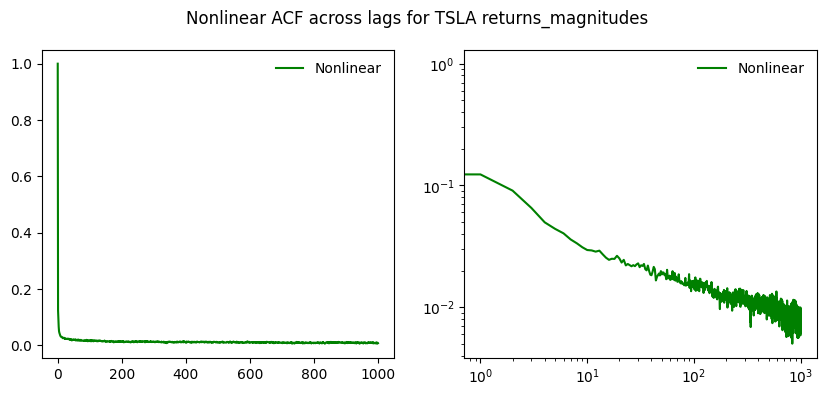

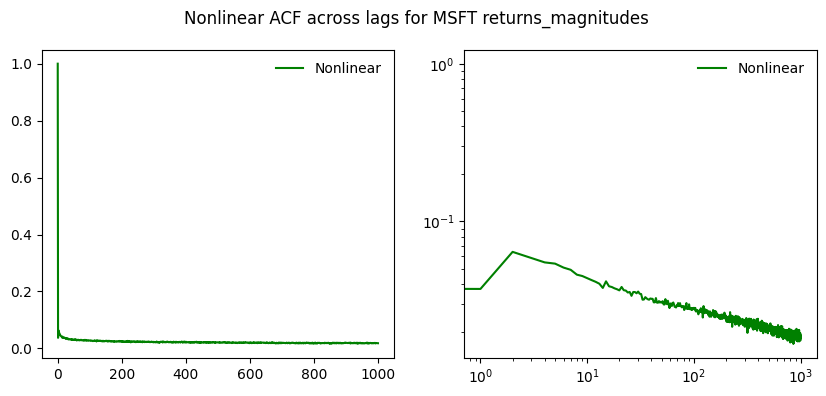

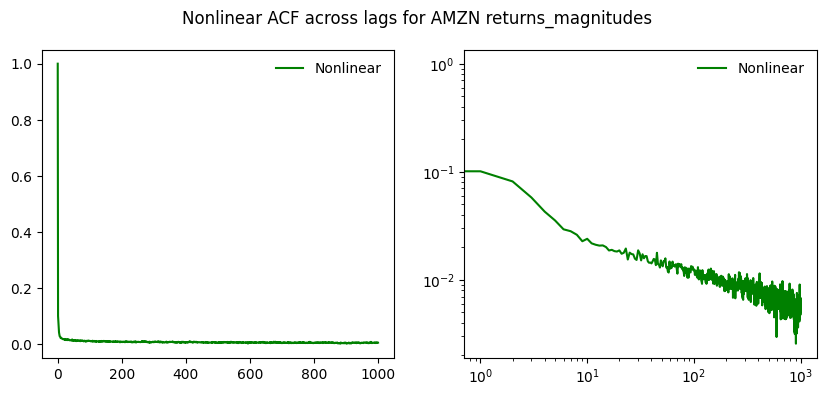

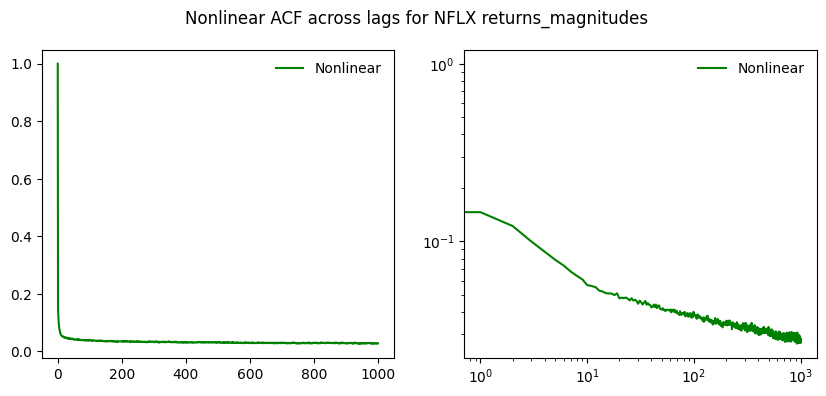

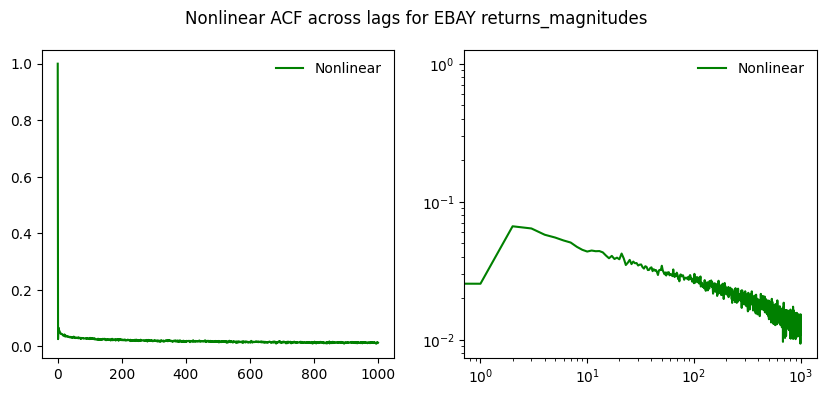

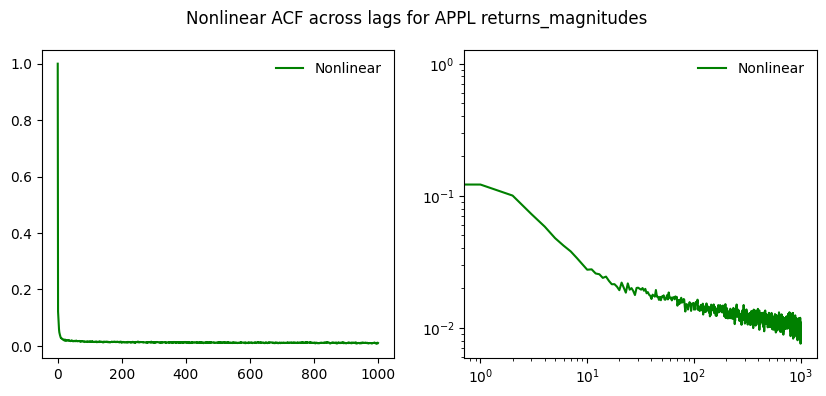

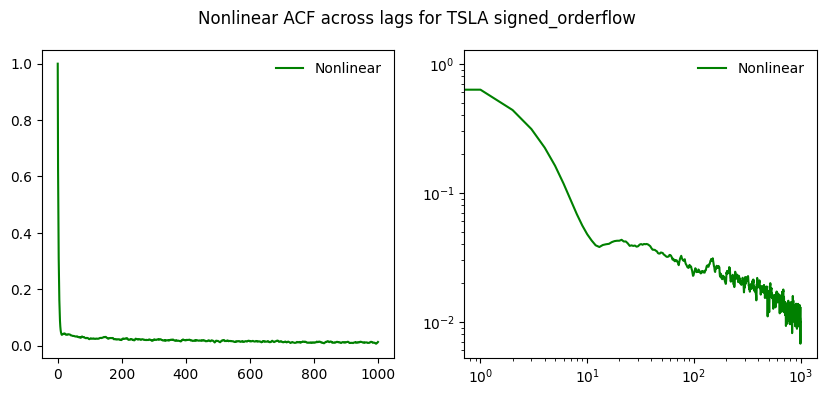

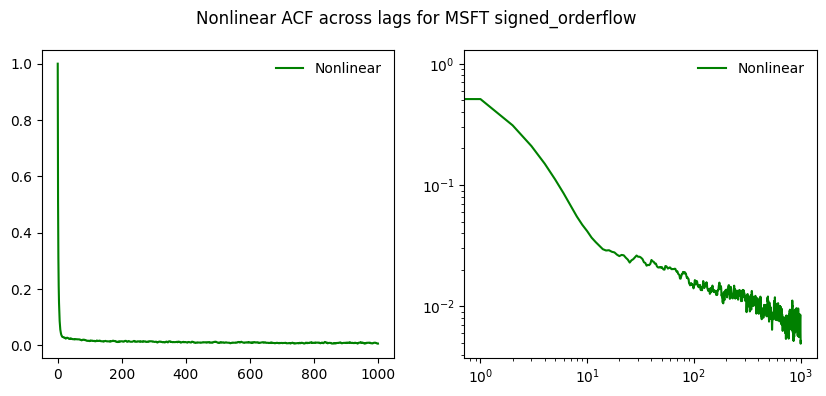

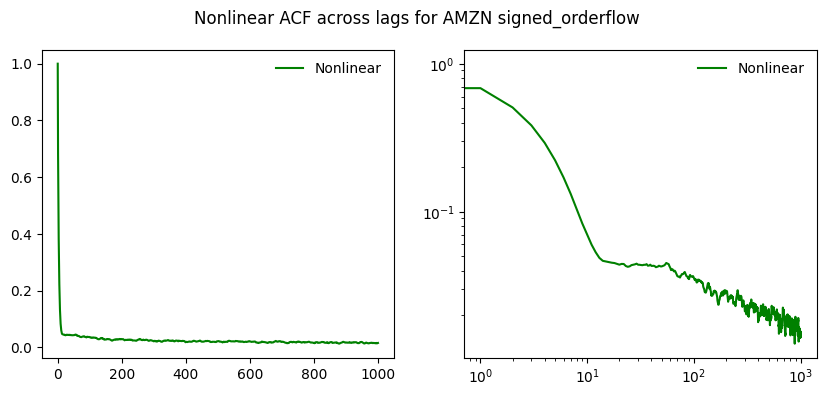

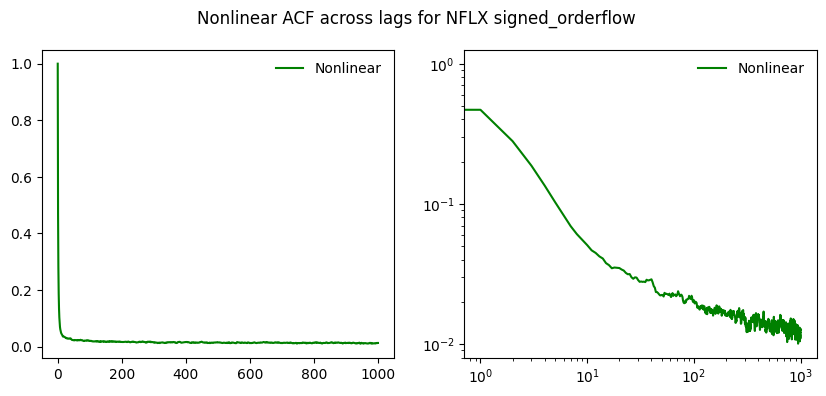

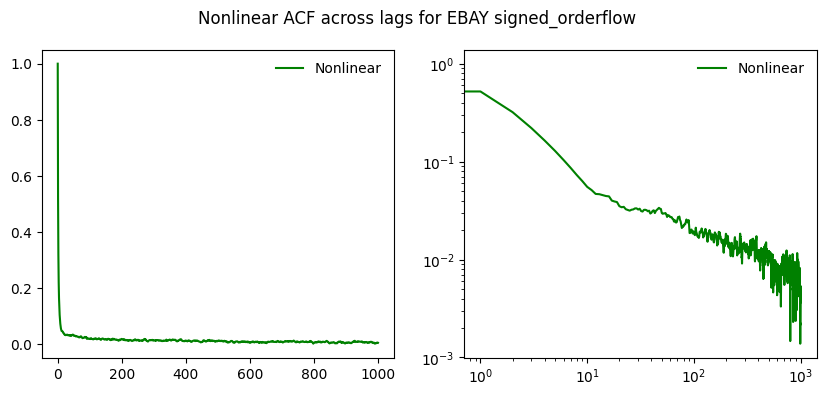

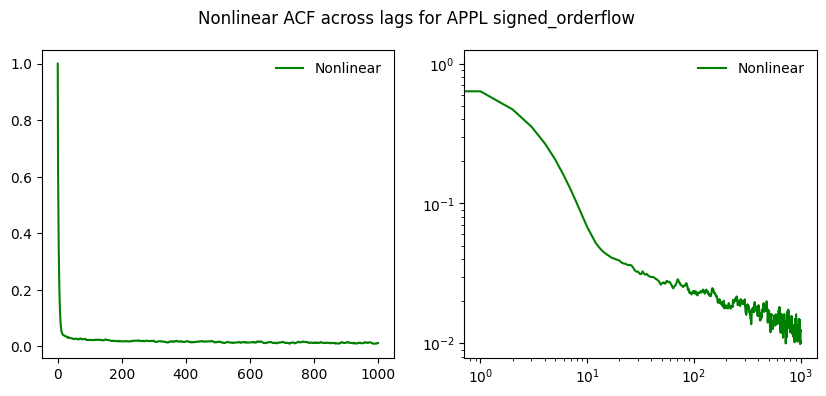

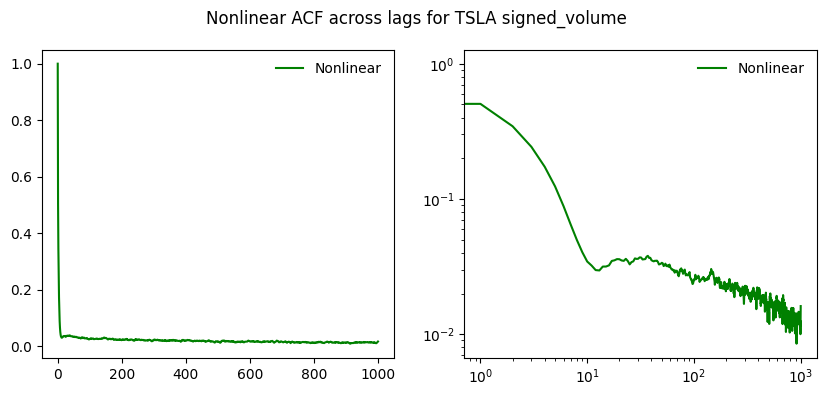

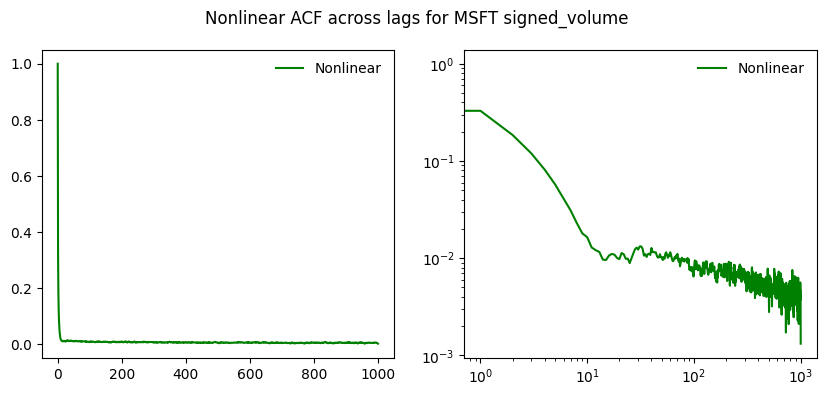

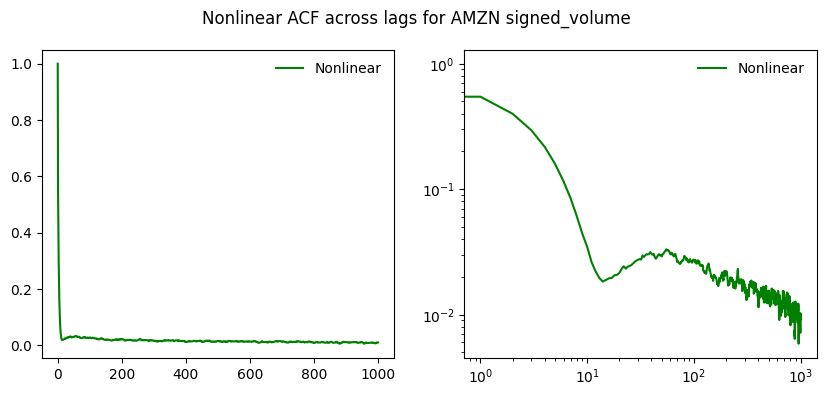

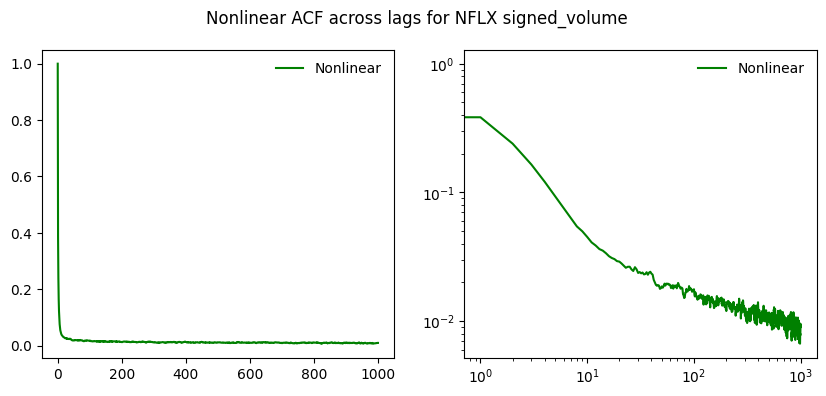

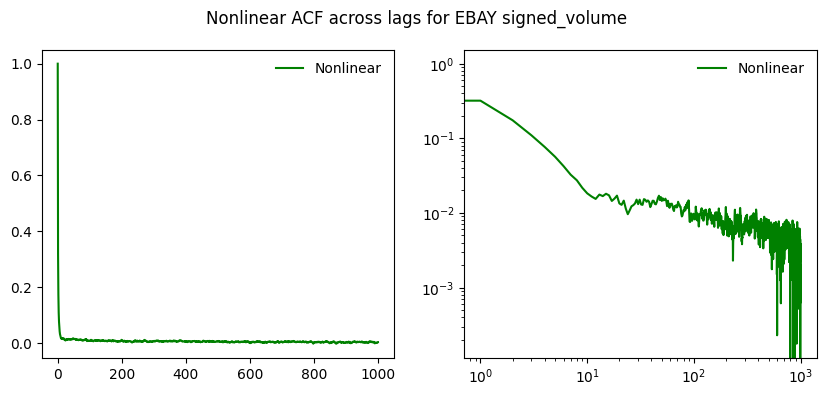

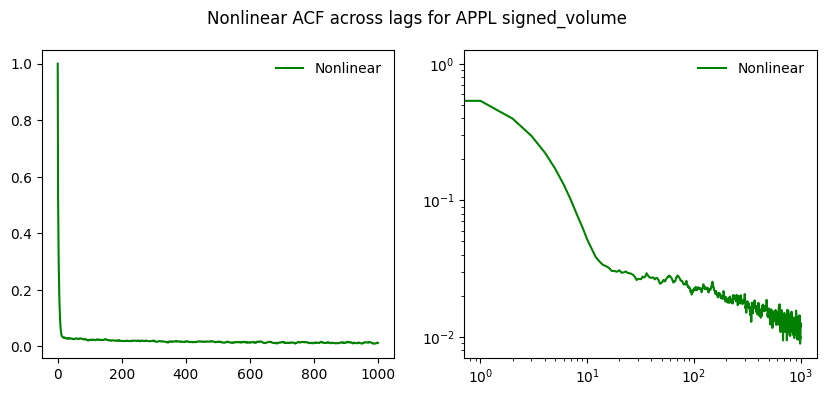

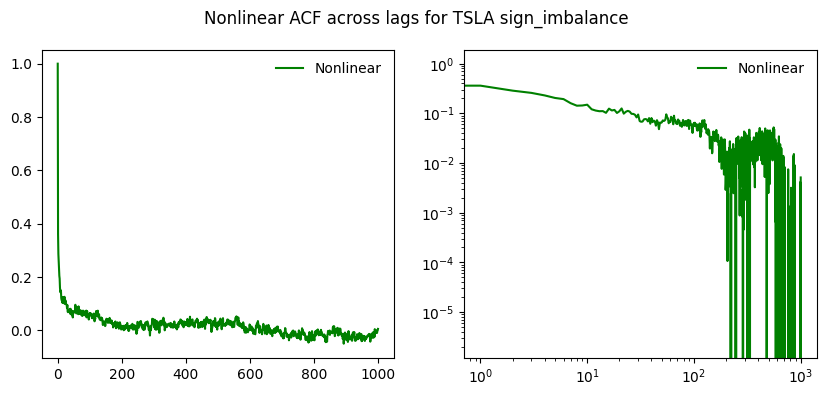

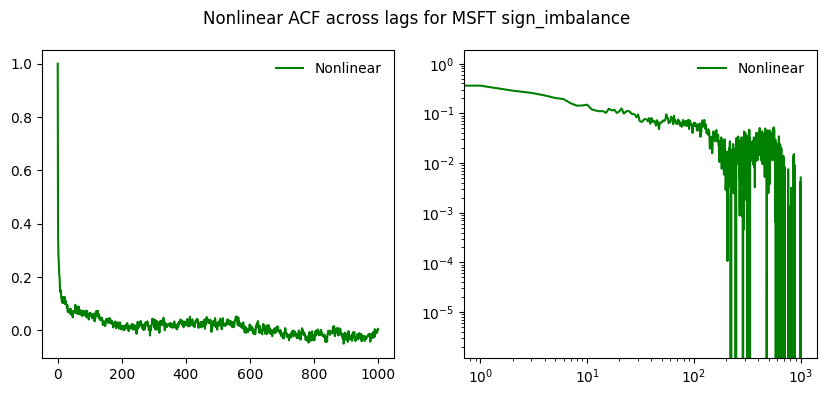

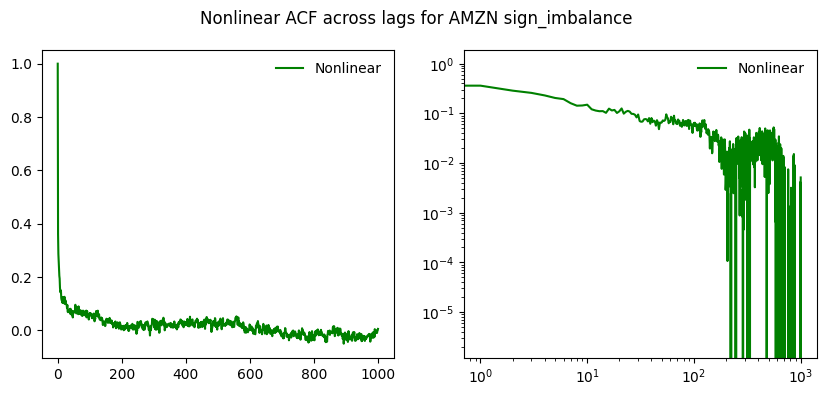

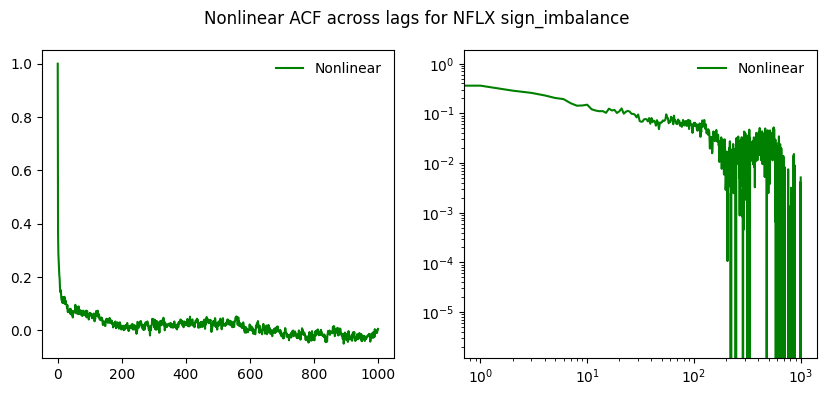

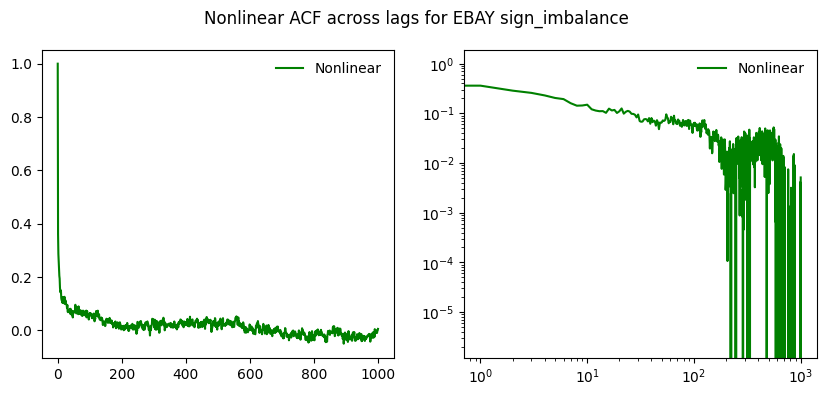

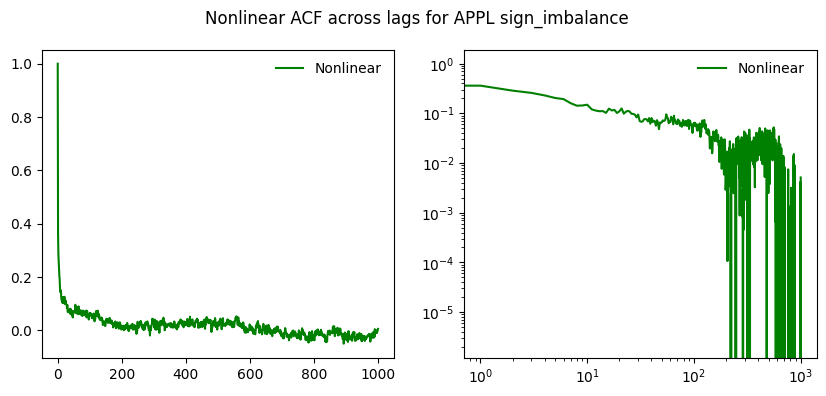

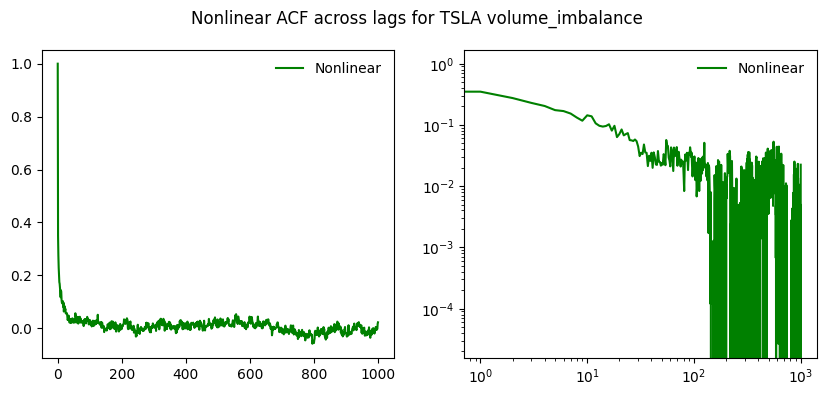

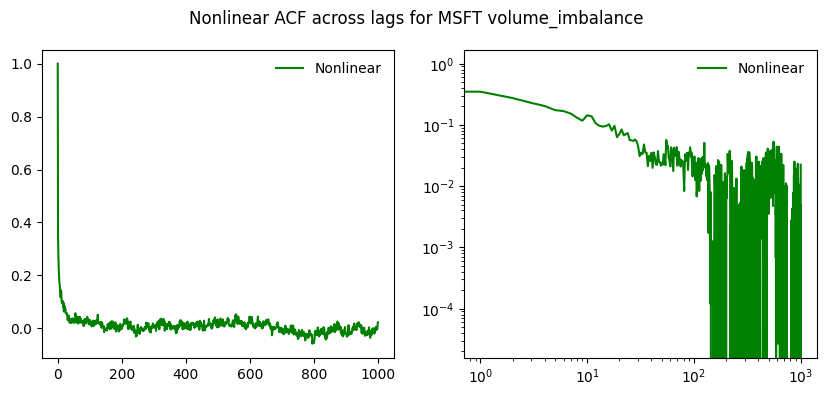

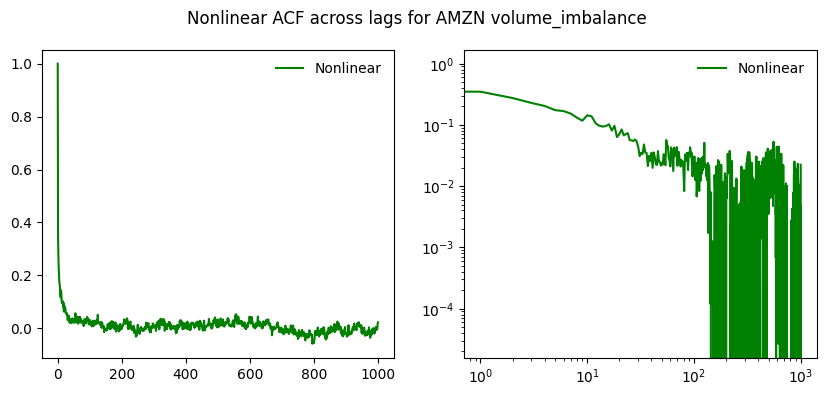

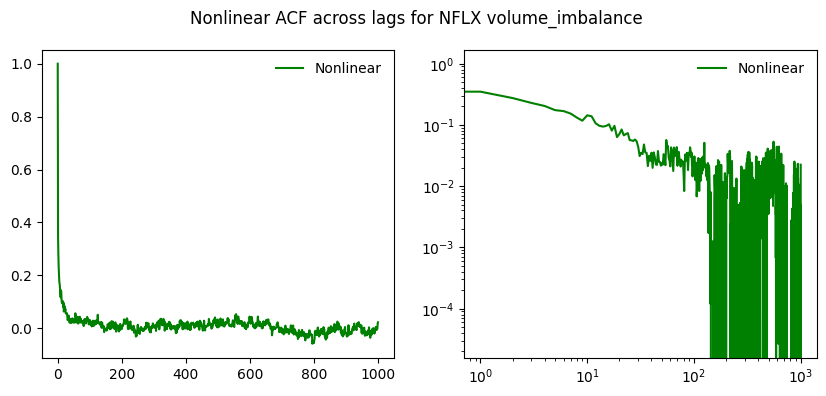

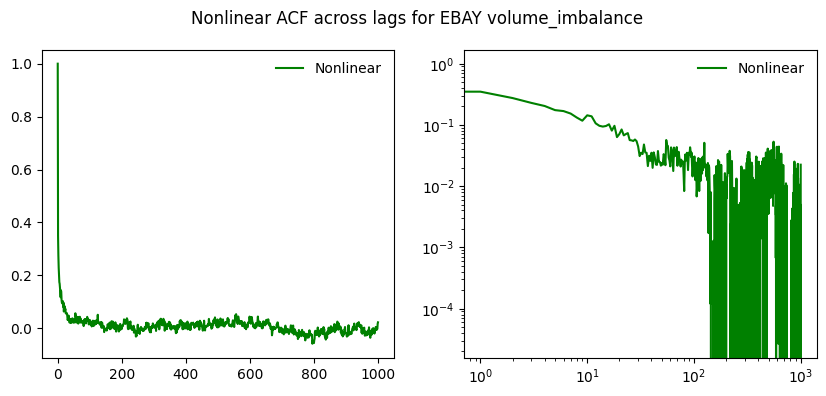

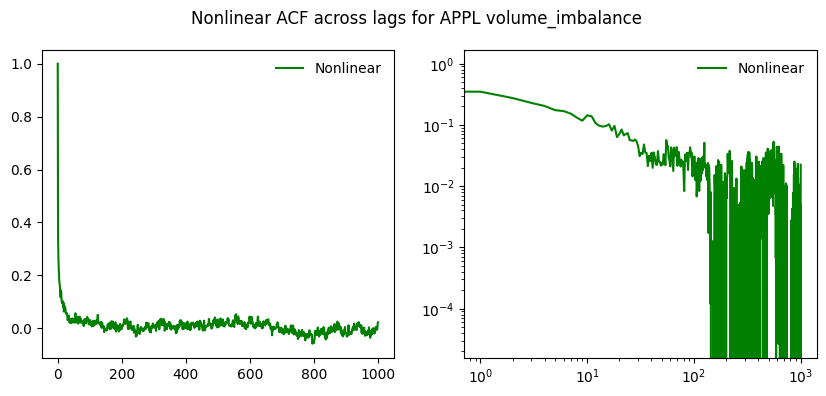

In [14]:
# Plot ACF for each dictionary and each stock
for random_variate, stocks_data in all_acfs_loaded.items():
    for stockname in stocks_data.keys():
        plot_acf(stockname, random_variate, stocks_data[stockname])

## 1.3. Test for Long memory

Infer an autocorrelation function from a finite return sample, and then we can fit a power-law to the inferred ACF to infer whether the process has long memory.

### 1.3.1. Estimate ACF scaling parameter

In [ ]:
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()

### Estimate 1.3.2. Hurst Exponent

In [ ]:
# Estimate Hurst Exponent using both Standard and Generalized metod
tsla_returns = compute_returns(tsla_raw_df, T=100000)['cumsum_returns']

hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()
print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")

In [ ]:
# Display the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

# ACF
tsla_alpha = tsla_acf_fit.powerlaw.params.alpha
tsla_acf_fit.powerlaw.plot_fit(data_kwargs={"label": f"Alpha: {tsla_alpha:.2f}"}, fit_kwargs={"ax": axes[0]})

# Hurst
fit_std.powerlaw.plot_fit(data_kwargs={"label": f"Hurst: {hurst_std:.2f}"}, fit_kwargs={"ax": axes[1]})
fit_gen.powerlaw.plot_fit(data_kwargs={"label": f"Hurst: {hurst_gen:.2f}"}, fit_kwargs={"ax": axes[2]})

### 3.1.3. For all assets

In [ ]:
# Construct values for each dimension, x- and y-axis, of our ACF
def construct_xy(sample: pd.Series, name: str) -> pd.DataFrame:
    """
    Constructs x and y values for a given series and its name.

    Parameters:
    - sample: Series containing y values
    - name: String representing the series' name

    Returns:
    - DataFrame with columns 'x_values' and 'y_values'
    """
    y_values = list(sample)
    if len(sample) != len(y_values):
        raise ValueError(f"Sample sizes mismatch for {name}.")

    xy_df = pd.DataFrame({
        'x_values': range(1, len(y_values) + 1),
        'y_values': y_values
    })

    return xy_df

return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)


tsla_cum_returns = compute_returns(tsla_raw_df, T=100000)['cumsum_returns']
amzn_cum_returns = compute_returns(amzn_raw_df, T=100000)['cumsum_returns']
nflx_cum_returns = compute_returns(nflx_raw_df, T=100000)['cumsum_returns']
msft_cum_returns = compute_returns(msft_raw_df, T=100000)['cumsum_returns']
ebay_cum_returns = compute_returns(ebay_raw_df, T=100000)['cumsum_returns']
appl_cum_returns = compute_returns(appl_raw_df, T=100000)['cumsum_returns']


cumsum_returns = {
  'TSLA': tsla_cum_returns,
  'AMZN': amzn_cum_returns,
  'NFLX': nflx_cum_returns,
  'MSFT': msft_cum_returns,
  'EBAY': ebay_cum_returns,
  'APPL': appl_cum_returns
}

# Iterate over each stock's ACF values
fit_results_list = []

# Iterate over each stock's ACF values and cumsum_returns
for stock, acf_values in return_acf_values.items():
    fit = Fit(acf_values)
    if hasattr(fit, 'powerlaw'):
        fit_dict = fit.powerlaw.to_dictionary()

        # Filter only if the function_name is 'powerlaw'
        if fit_dict.get("function_name") == "powerlaw":

            # Extract 'alpha' and other parameters directly
            alpha = fit.powerlaw.params.alpha
            C = fit.powerlaw.params.C

            # Compute Hurst Exponents for the cumsum_returns of the stock
            cum_returns = cumsum_returns[stock]
            hurst_std, fit_std = standard_hurst(cum_returns)
            hurst_gen, fit_gen = generalized_hurst(cum_returns)

            # Update the dictionary
            fit_dict.update({
                'alpha': alpha,
                'C': C,
                'hurst_std': hurst_std,
                'hurst_gen': hurst_gen,
                'stock': stock
            })

            fit_results_list.append(fit_dict)

In [ ]:
# Convert the list of dictionaries into a dataframe
fit_results = pd.DataFrame(fit_results_list)
fit_results